Populating the interactive namespace from numpy and matplotlib



# Class data

In [67]:
%matplotlib inline
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt
import plotly
import numpy as np
import pandasql as pdsql
import requests
import io

class Data(object):
    
    """
    Load 911 calls data from the https://storage.googleapis.com/montco-stats/tz.csv
    """
    __db = pd.DataFrame()
    __db_ems = None
    __db_fire = None
    __db_police = None
    
    realtime_or_local = ""
    __is_realtime = False
    __db_is_updated = False
    __db_ems_is_updated = False
    __db_fire_is_updated = False
    __db_police_is_updated = False
    
    __local_filename = ""
    
    def __init__(self, realtime_or_local="realtime", local_filename=''):
        
        """
        parameters
        ----------
        realtime_or_local ="realtime" or "local"
        local_filename = e.g, '/users/dataset.csv'  if "local"
        """
        self.__local_filename = local_filename
        self.realtime_or_local = realtime_or_local
        
        self.url = "https://storage.googleapis.com/montco-stats/tz.csv"
        self.col_names = ['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'twp', 'e']
        self.col_type = {'lat': float, 'lng': float, 'desc': str, 'zip': str,
                         'title': str, 'timeStamp': str, 'twp': str, 'e': int}
        
        self.update()
        
        
    def update(self):
        if self.realtime_or_local=='realtime':
            self.__is_realtime = True
            self.__load_realtime()
            
        else: 
            if self.realtime_or_local=='local':
                self.__is_realtime = False
                self.load_local(self.__local_filename)
            else:
                raise ValueError('The Data object can be realtime or local')
        
        self.add_data_time_columns()
        
        __db_ems_is_updated = False
        __db_fire_is_updated = False
        __db_police_is_updated = False
        self.__db_is_updated = True
        
        
    def __load_realtime(self):
        
        """
        load the data in realtime from the google api
        https://storage.googleapis.com/montco-stats/tz.csv
        """
        
        df = requests.get(self.url).content
        df = pd.read_csv(io.StringIO(df.decode('utf-8')), header=0,
                         names=self.col_names, dtype=self.col_type)
        self.__db = pd.DataFrame(df)
        return self.__db

    
    def load_local(self, file_name):
        """
        load the data from the local directory with name indicated
        """
        d = pd.read_csv(file_name, header=0, names=self.col_names, dtype=self.col_type)
        self.__db = pd.DataFrame(d)
        return self.__db
    
    
    def save(self, dir, name):
        """
        save the data frame in the local directory  with name indicated
        """
        self.__db.to_csv(dir + name)

    
    def db(self, doUpdate=False):
        """
        it returns all 911 calls db 
        
        parameters
        ----------
        doUpdate = True  - reaload the db 
        doUpdate = False - do not reload return the local copie (default)
         
        """
        if doUpdate or (not self.__db_is_updated):
            self.__update(self)
            self.__db_is_updated = True
        
        return self.__db
    
    def db_ems(self, doUpdate=False):
        """
        it returns the 911 ems calls db 
        
        parameters
        ----------
        doUpdate = True  - reaload the db 
        doUpdate = False - do not reload return the local copie (default)
         
        """
        if doUpdate or (not self.__db_ems_is_updated):
            self.__db_ems = self.get_db_type(1)
            self.__db_ems_is_updated = True
        
        return self.__db_ems
    
    
    def db_fire(self, doUpdate=False):
        """
        it returns the 911 fire calls  db 
        
        parameters
        ----------
        doUpdate = True  - reaload the db 
        doUpdate = False - do not reload return the local copie (default)
         
        """
        if doUpdate or (not self.__db_ems_is_updated):
            self.__db_fire =  self.get_db_type(2)
            self.__db_fire_is_updated = True
        
        return self.__db_fire

    
    def db_police(self, doUpdate=False):
        """
        it returns the 911 police calls db 
        parameters
        ----------
        doUpdate = True  - reaload the db 
        doUpdate = False - do not reload return the local copie (default)
         
        """
        if doUpdate or (not self.__db_ems_is_updated):
            self.__db_police =  self.get_db_type(3)
            self.__db_police_is_updated = True
        
        return self.__db_police
    
    
    # type_db = 1 'EMS'
    # type_db = 2 'Fire'
    # type_db = 3 'Traffic'
    # type_db = any number 'all'
    def get_db_type(self, type_db):

        if type_db == 1:
            sql1 = "select * from DB where title like 'EMS:%'"
            d3 = pdsql.sqldf(sql1, {'DB':self.__db})
            self.__db_ems = pd.DataFrame(d3)
            return self.__db_ems 
        
        if type_db == 2:
            sql1 = "select * from DB where title like 'Fire:%'"
            d3 = pdsql.sqldf(sql1, {'DB':self.__db})
            self.__db_fire = pd.DataFrame(d3)
            return self.__db_fire 
        
        if type_db == 3:
            sql1 = "select * from DB where title like 'Traffic:%'"
            d3 = pdsql.sqldf(sql1, {'DB':self.__db})
            self.__db_police = pd.DataFrame(d3)
            return self.__db_police 
        
        return -1

    
    def add_data_time_columns(self): 
    
        # ADD THE DATE AND TIME IN SINGLE COLUMNS FOR GROUPPING THE CALLS BY HOURS
        dt1 = np.zeros((self.__db.shape[0], 4))

        for i in range(0,self.__db.shape[0]):
            s = self.__db.timeStamp[i]
            s = s.split(' ')
            ymd = s[0].split('-')
            hms = s[1].split(':')
            dt1[i,0]=int(ymd[0])
            dt1[i,1]=int(ymd[1])
            dt1[i,2]=int(ymd[2])
            dt1[i,3]=int(hms[0])

        dt1 = pd.DataFrame(dt1)
        dt2 = pd.concat([self.__db,dt1], axis=1)

        names = dt2.columns.tolist()
        names[names.index(0)] = 'year'
        names[names.index(1)] = 'month'
        names[names.index(2)] = 'day'
        names[names.index(3)] = 'hour'
        dt2.columns = names
        dt2 = pd.DataFrame(dt2)

        self.__db = dt2

        return self.__db
    
    
    # UTILITY FUNCTIONS
    def tserie_callshour(self, df):
        sql1 = "select year, month, day, hour, count(*) as calls from dt2 group by year, month, day, hour"
        dt3 = pdsql.sqldf(sql1, {'dt2':df})
        dt3 = pd.DataFrame(dt3)
        
        dt3.index = pd.to_datetime(dt3.loc[:, ['year', 'month', 'day', 'hour']])

        del dt3['year']
        del dt3['month']
        del dt3['day']
        del dt3['hour']
        
        return dt3
    
    def tserie_callsday(self,df):
        sql1 = "select year, month, day, count(*) as calls from dt2 group by year, month, day"
        dt3 = pdsql.sqldf(sql1, {'dt2':df})
        dt3 = pd.DataFrame(dt3)
        
        dt3.index = pd.to_datetime(dt3.loc[:, ['year', 'month', 'day']])
        
        del dt3['year']
        del dt3['month']
        del dt3['day']
        
        return dt3
    

In [76]:
# TEST
#-----
dt911 = Data('local', './test.csv')
dt911 = Data('realtime')

df_all = dt911.db()
df_ems = dt911.db_ems()
df_fire = dt911.db_fire()
df_police = dt911.db_police()

df_ems.head()

,lat,lng,desc,zip,title,timeStamp,twp,e,year,month,day,hour
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,1,2015.0,12.0,10.0,17.0
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,1,2015.0,12.0,10.0,17.0
2,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,1,2015.0,12.0,10.0,17.0
3,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,None,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,1,2015.0,12.0,10.0,17.0
4,40.253473,-75.283245,CANNON AVE & W 9TH ST; LANSDALE; Station 345;...,19446,EMS: HEAD INJURY,2015-12-10 17:40:01,LANSDALE,1,2015.0,12.0,10.0,17.0


In [68]:
# ---------------
# LOAD DB
# --------------

dt911 = Data('local', './test.csv')

df_all = dt911.db()
df_ems = dt911.db_ems()




In [58]:
ts_day = dt911.tserie_callsday(df_ems)
ts_day.head()

,calls
2015-12-10,57
2015-12-11,186
2015-12-12,189
2015-12-13,190
2015-12-14,222


In [55]:
ts_hour = dt911.tserie_callshour(df_ems)
ts_hour.head()

,calls
2015-12-10 17:00:00,11
2015-12-10 18:00:00,8
2015-12-10 19:00:00,15
2015-12-10 20:00:00,10
2015-12-10 21:00:00,2


## day stats

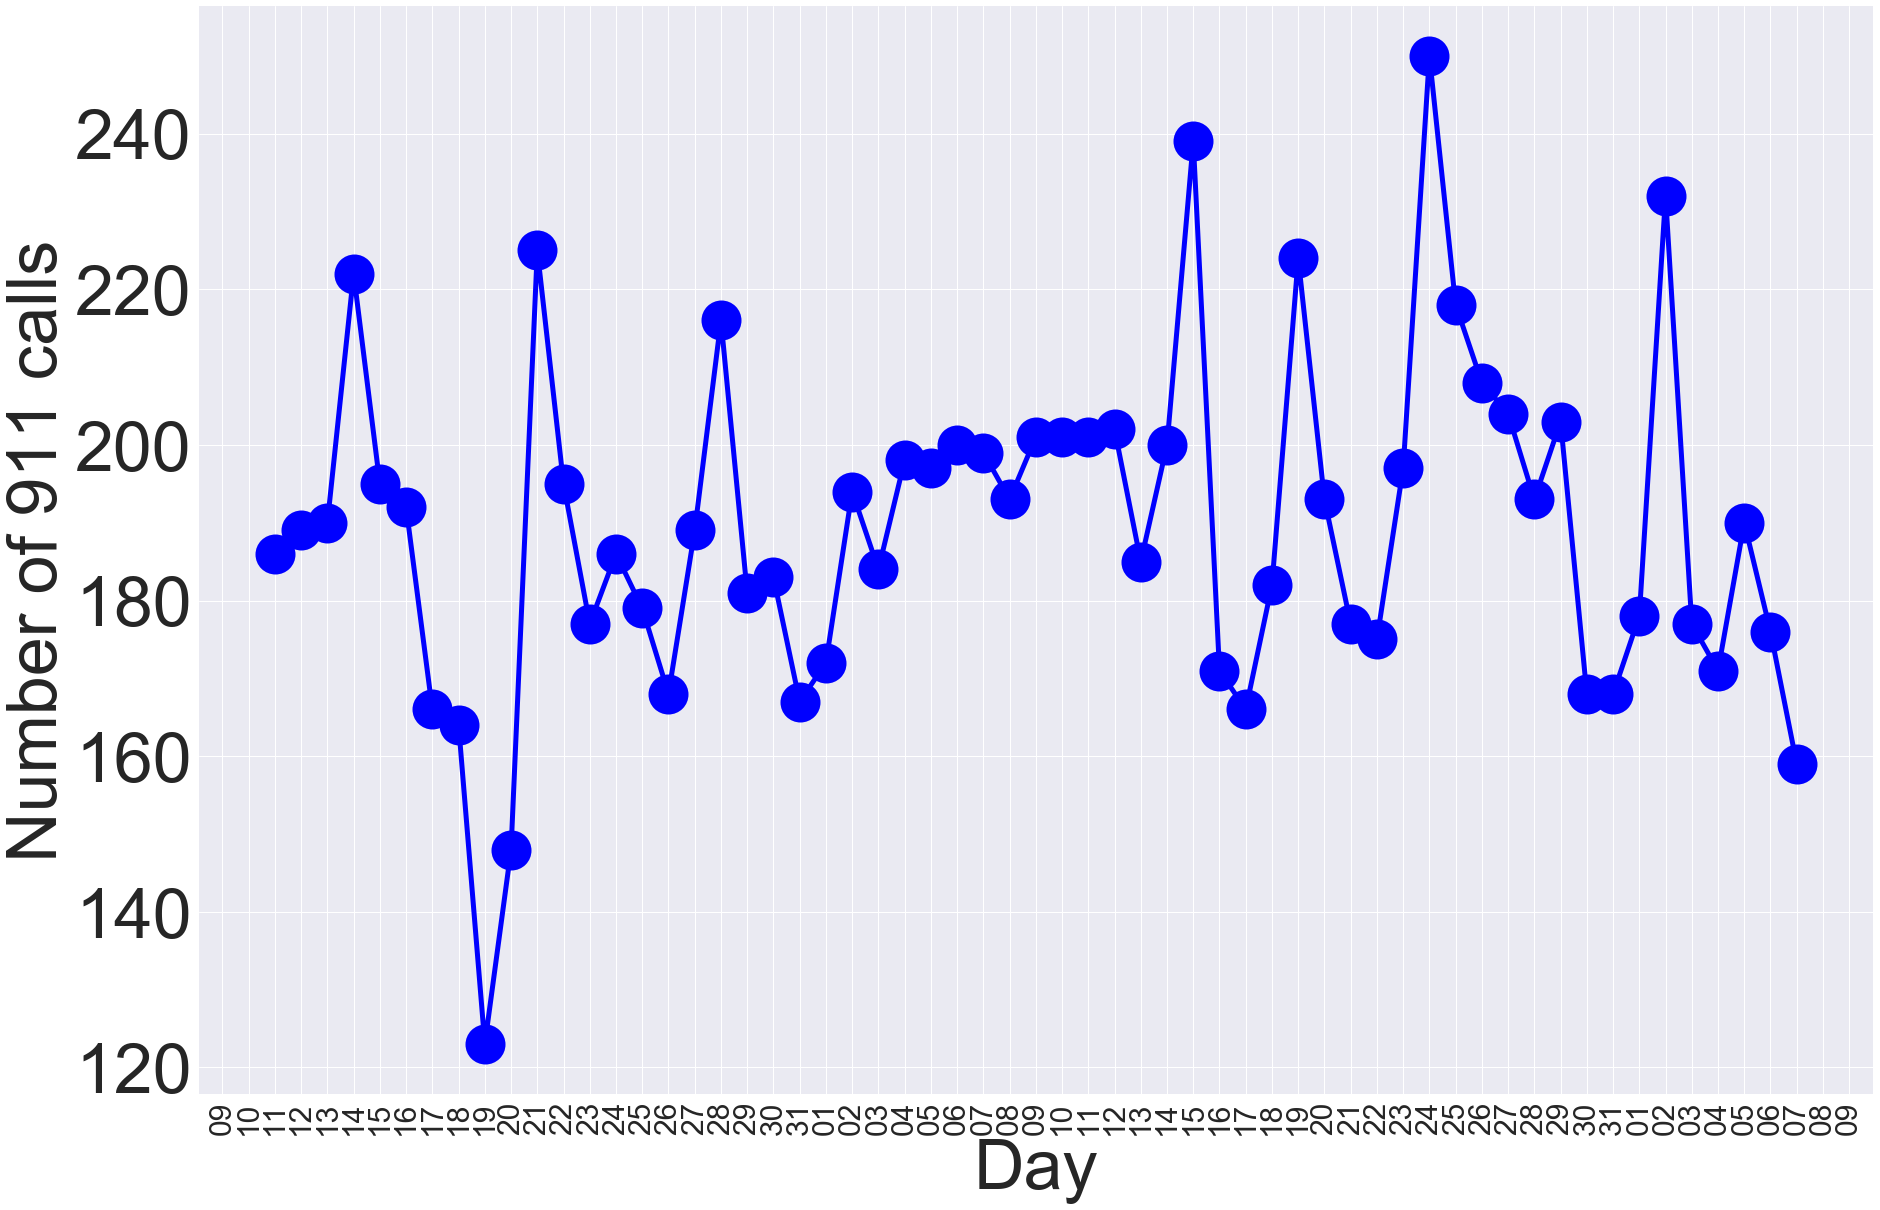

In [70]:
#plt.boxplot(df2['calls'])
import matplotlib.dates as md
from matplotlib import ticker


yy = ts_day.calls[1:60]



tick_spacing = 1
fig, ax = plt.subplots(figsize=(30,20));
plt.plot(yy, '-b', lw=5)
plt.plot(yy, '.b', markersize=80)

#plt.fill_between(xx, yy-4, yy+4, facecolor='b', alpha=0.1) 

xfmt = md.DateFormatter('%d')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks( rotation=90 )

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


# plot the ideal prediction
plt.xlabel('Day', fontsize=70)
plt.ylabel('Number of 911 calls', fontsize=70)
plt.tick_params(axis='y', which='both', labelleft='on', labelsize=70)
plt.tick_params(axis='x',  labelsize=30)


## day to day change distribution

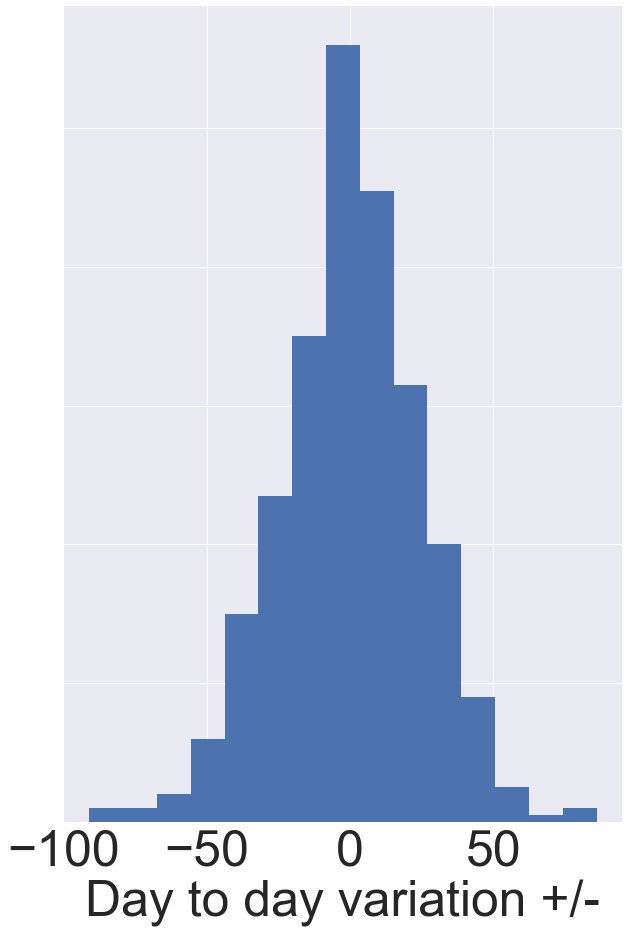

In [110]:
a = 1
b = 500

yy_dif = np.array(ts_day.calls[a:b]) - np.array(ts_day.calls[a+1:b+1])

tick_spacing = 1
fig, ax = plt.subplots(figsize=(10,15));
plt.hist(yy_dif, 15)

# plot the ideal prediction
plt.xlabel('Day to day variation +/-', fontsize=50)
#plt.ylabel('Frequency', fontsize=70)
plt.tick_params(axis='y', which='both', labelleft='off', labelsize=40)
plt.tick_params(axis='x',  labelsize=50, color='blue')



In [6]:
ts_day


,year,month,day,calls
2015-12-10 23:37:00,2015.0,12.0,10.0,57
2015-12-11 23:42:02,2015.0,12.0,11.0,186
2015-12-12 23:56:00,2015.0,12.0,12.0,189
2015-12-13 23:56:01,2015.0,12.0,13.0,190
2015-12-14 23:57:01,2015.0,12.0,14.0,222
2015-12-15 23:56:00,2015.0,12.0,15.0,195
2015-12-16 23:37:01,2015.0,12.0,16.0,192
2015-12-17 22:42:00,2015.0,12.0,17.0,166
2015-12-18 22:32:01,2015.0,12.0,18.0,164
2015-12-19 23:31:00,2015.0,12.0,19.0,123


## hour stats

/Users/remi/anaconda/envs/remi_insight/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()



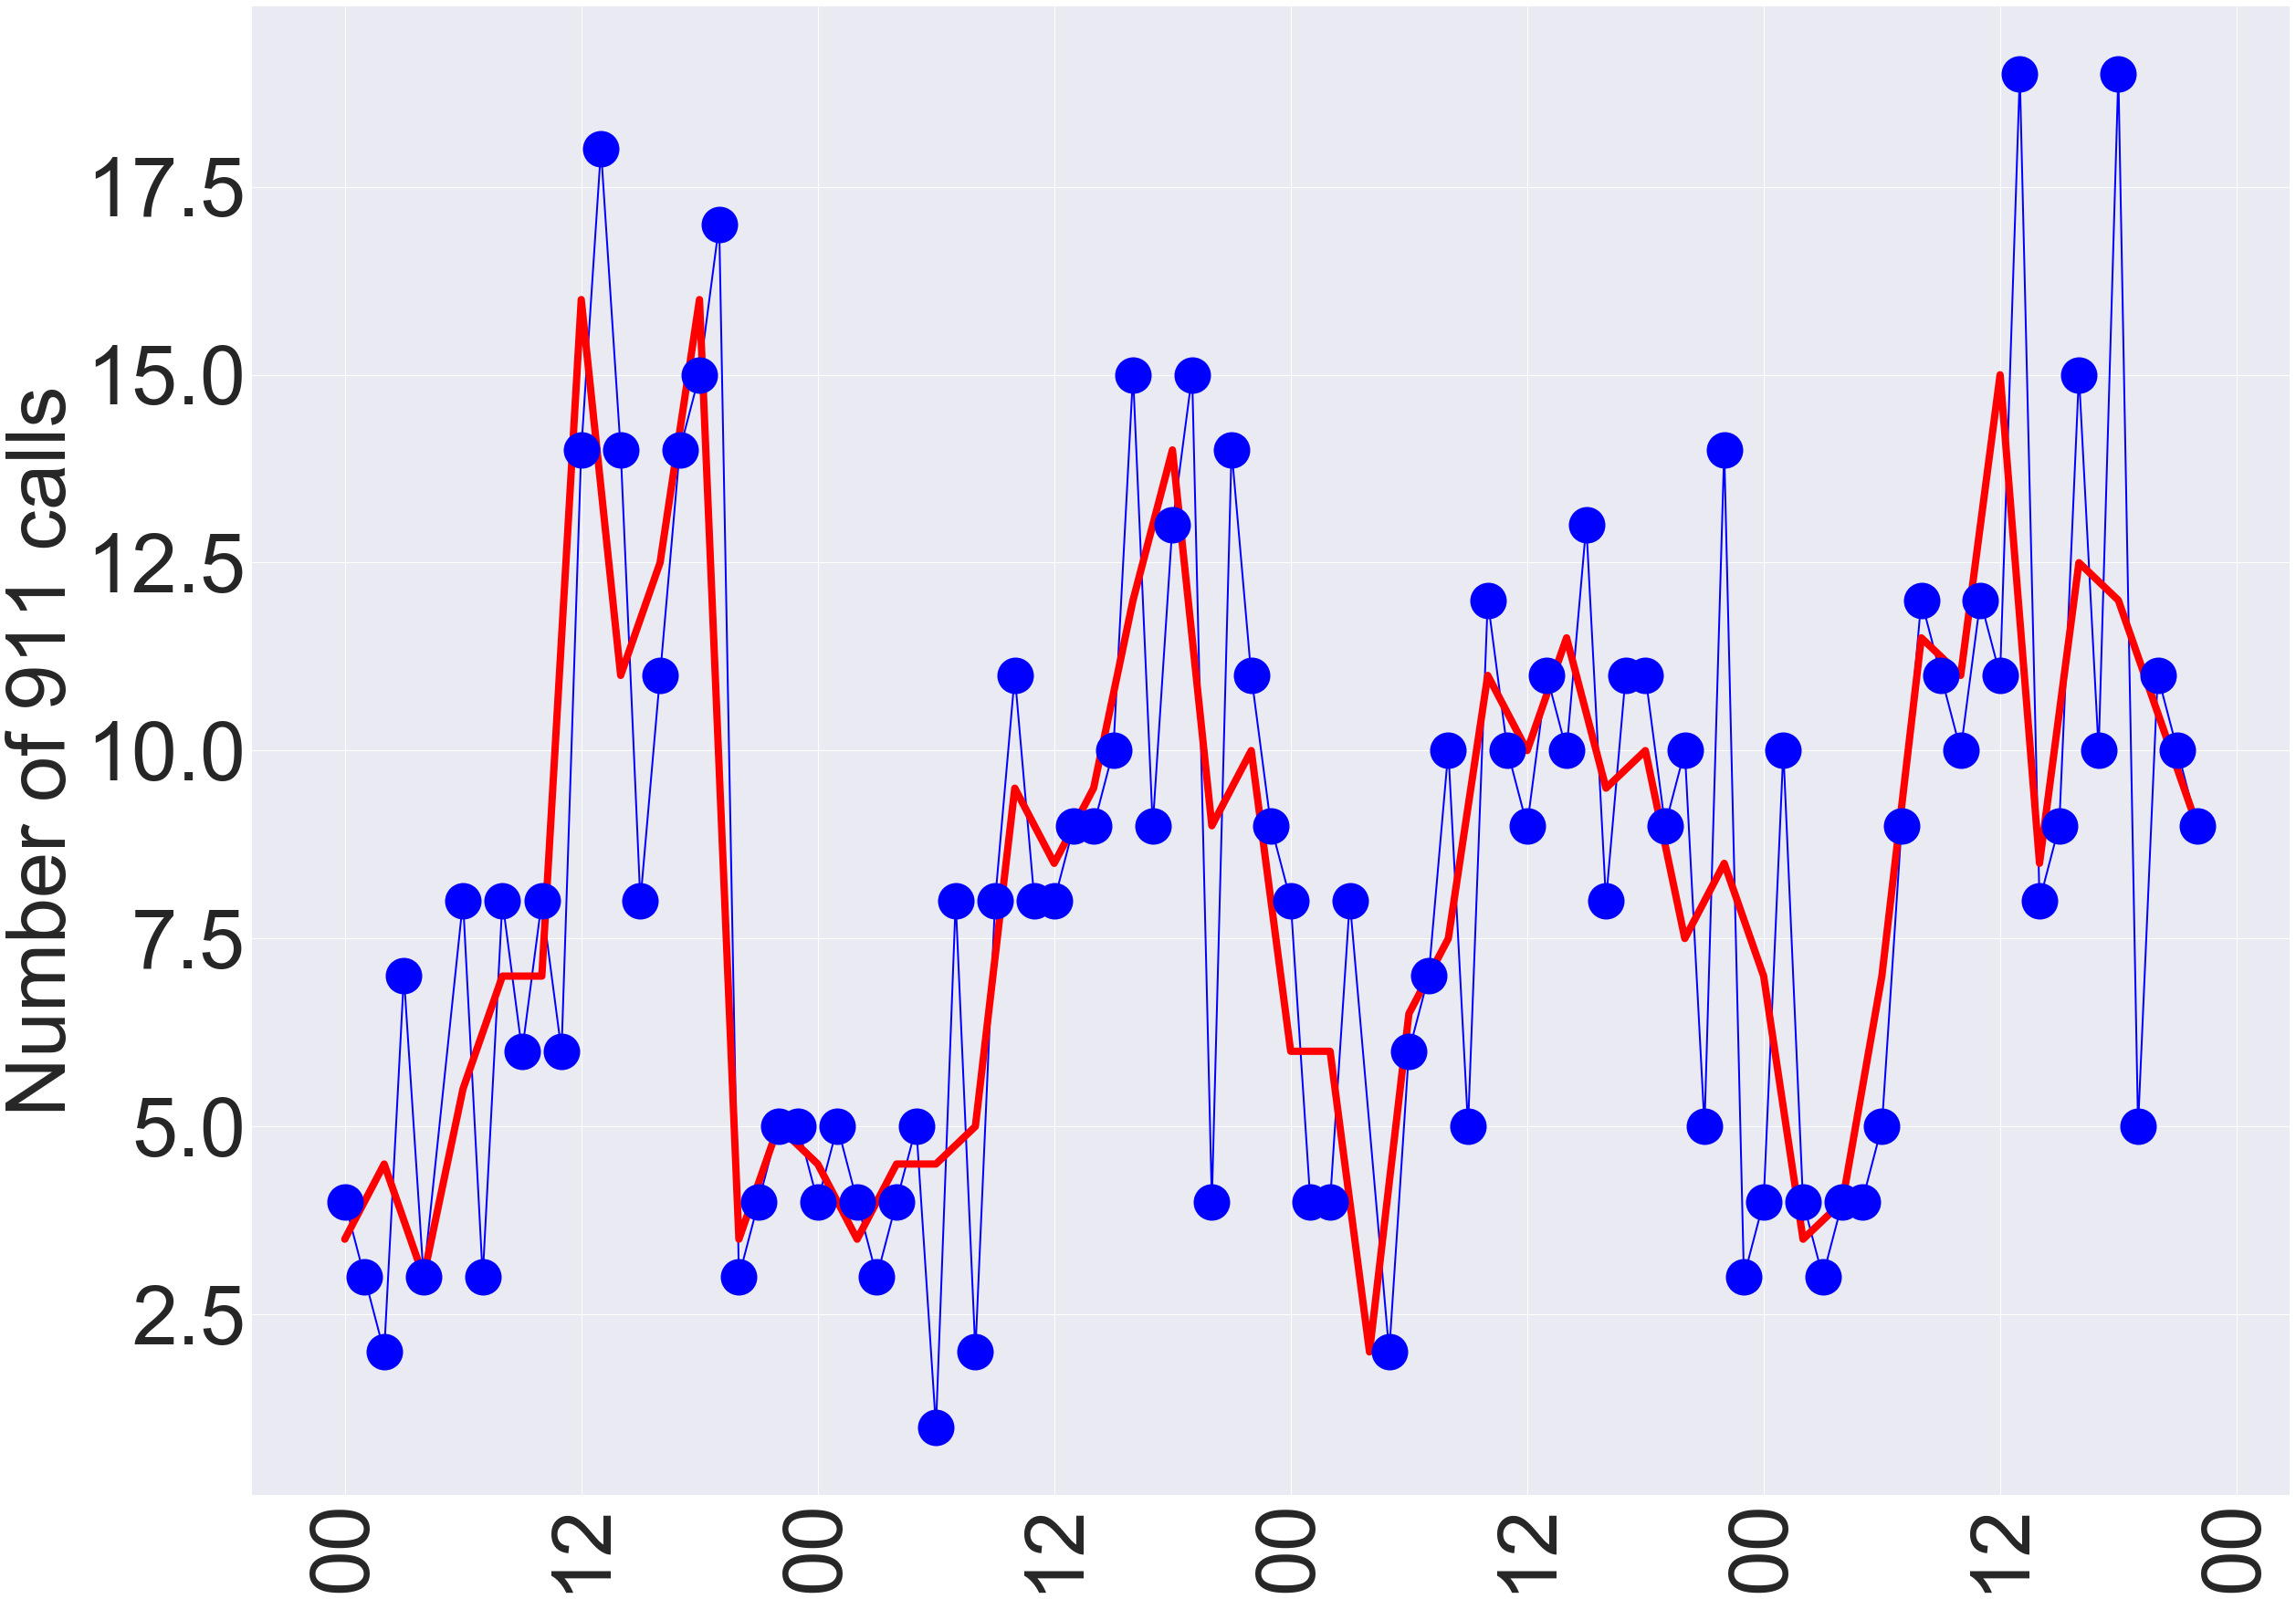

In [65]:
#plt.boxplot(df2['calls'])
import matplotlib.dates as md
from matplotlib import ticker

yy = ts_hour[7:100]
yy_res = ts_hour[7:100].resample('2H', how='mean')
yy_inter = yy_res.interpolate(method='spline', order=3)

#yy = ts_hour['calls'][250:350]
#yy = ts['calls'][7:300]
#xx = []
#for i in range(0,28):
#    xx.append(i)
#xx = np.array(xx)

tick_spacing = 0.5
fig, ax = plt.subplots(figsize=(40,30));
plt.plot(yy, '-b', lw=2)
plt.plot(yy_inter, '-r', lw=8)
plt.plot(yy, '.b', markersize=80)

#plt.fill_between(xx, yy-4, yy+4, facecolor='b', alpha=0.1) 

xfmt = md.DateFormatter('%H')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks( rotation=90 )

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


# plot the ideal prediction
#plt.xlabel('Hour', fontsize=90)
plt.ylabel('Number of 911 calls', fontsize=90)
plt.tick_params(axis='y', which='both', labelleft='on', labelsize=90)
plt.tick_params(axis='x',  labelsize=90)